Phase shift extraction code from interference data

Imports and adding path

In [1]:
# add path:
import sys
# sys.append(r"C:\Users\User\z\Desktop\WUT\Diplomka\ZPRACOVÁNÍ\Data testing\processing_project")
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..')) # Go up two levels from current path (from src/ to project root)
sys.path.append(project_root)
# add my library:
import global_utils
import global_constants
print(global_constants.__file__)
import global_functions_im
import utils
import functions_image_crop
import functions_phase_shift
import functions_abel
import functions_electron_density_analysis
# run this command to install all requirements:
#       pip install -r project_abel/requirements.txt
#       for pyAble a lower version of python is needed
# ------- miscellaneous imports: -------
import matplotlib.pyplot as plt
import tifffile as tiff # Loads .tiff as a NumPy array
import numpy as np # low level image manipulation (matrix)
import cmasher as cmr # extra colormaps
# from cmap import Colormap
# from scipy.ndimage import gaussian_filter1d
# from scipy.signal import correlate
# from skimage.feature import peak_local_max
# from skimage.restoration import unwrap_phase
from scipy.ndimage import gaussian_filter
# import abel
# ------- enables interactive window plot ---------
# %matplotlib notebook

C:\Users\User\z\Desktop\WUT\Diplomka\ZPRACOVÁNÍ\Data testing\processing_project\global_constants.py


Choosing path

In [2]:
"""
path = constants.base_dir
data_folders = global_utils.get_folder_names(path) # ['IDEA program+ cvicna data', 'Images', 'Spectra']
path2 = os.path.join(path, data_folders[1])
wavelength_folders = global_utils.get_folder_names(path2) # ['1064 nm', '2090 nm']
# 0) ['H0_3_28_25', 'H6_3_31_25']
# 1) ['Cu', 'H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'wrong']
path3 = os.path.join(path2, wavelength_folders[0])
sample_folders = global_utils.get_folder_names(path3)
# ['(1) 50-1000ns', '(2) 1000 - 2000 ns', '(3) 2-5us', '(4) 5-14.5us', '(5) 15-100us', '(6) 100-525us', '(7) 500us-2ms', 'reference x1', 'reference x2', 'reference x4', 'wrong beginning']
path4 = os.path.join(path3, sample_folders[0])
measurement_folders = global_utils.get_folder_names(path4)
print(data_folders)
print(wavelength_folders)
print(sample_folders)
print(measurement_folders)
"""
# files
print("--- Files ---")
# path_img_files = os.path.join(path4, folders4[1])
# files_img = global_utils.get_file_names(path_img_files)
# path_ref_files = os.path.join(path4, folders4[9])
# files_ref = global_utils.get_file_names(path_ref_files)
# image path creation
# img_path = os.path.join(path_img_files, files_img[85]) # 85 - H0_3_28_25\(2) 1000 - 2000 ns\M7_X10.tif
# ref_path = os.path.join(path_ref_files, files_ref[19]) # 19 - H0_3_28_25\reference x4\REF_X9.tif

# ------ 2090 nm ------
# path_img_files = os.path.join(path4, folders4[1])
# path_ref_files = os.path.join(path, folders[1], folders2[1], folders3[9])

path_img_files = global_constants.dir_1064_H6_3
path_ref_files = global_constants.dir_1064_x2_H6

files_img = global_utils.get_file_names(path_img_files)
files_img = global_utils.filter_by_M_exact(
    files_img,
    exact = 6
)
print(files_img)
img_path = os.path.join(path_img_files, files_img[6]) # 
files_ref = global_utils.get_file_names(path_ref_files)
ref_path = os.path.join(path_ref_files, files_ref[1]) # 
print(img_path)
print(ref_path)


# --- x2 ---
# files_img = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[2])
# img_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[2] + "\\" + files_img[0]
# files_ref = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[8])
# ref_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[8] + "\\" + files_ref[1]
# 1x ------
# files_img = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[6])
# img_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[6] + "\\" + files_img[0]
# files_ref = global_utils.get_file_names(path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[7])
# ref_path = path + "\\" + folders[1] + "\\" + folders2[0] + "\\" + folders3[0] + "\\" + folders4[7] + "\\" + files_ref[1]


--- Files ---
['M6_X1.tif', 'M6_X2.tif', 'M6_X3.tif', 'M6_X4.tif', 'M6_X5.tif', 'M6_X6.tif', 'M6_X7.tif', 'M6_X8.tif']
C:\Users\User\z\Desktop\WUT\Diplomka\DATA\Images\1064 nm\H6_3_31_25\(3) 2-5us\M6_X7.tif
C:\Users\User\z\Desktop\WUT\Diplomka\DATA\Images\1064 nm\H6_3_31_25\reference x2\REFx2_X12.tif


Loading practice data

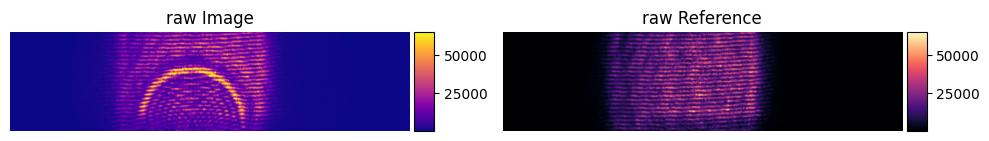

In [3]:
img = tiff.imread(img_path)
ref = tiff.imread(ref_path)

colormap = cmr.nuclear
#global_functions_im.plot_two_images(img, ref, title1='raw Image', title2='raw Reference',cmap=colormap)
fig = global_functions_im.plot_two_images(
    img, ref, title1='raw Image', title2='raw Reference',
    cmap1='plasma', cmap2='magma',
    colorbar=True,
    share_color_scale=False
)
# global_functions_im.plot_two_images(img, ref, title1='raw Image', title2='raw Reference',cmap=colormap)

Auto crop function with a constant size for:
x4: 721 px - 40 px
x2: 433 px - 20 px
x1: 235 px - 20 px

In [4]:
profile1 = functions_image_crop.get_horizontal_intensity_sum(img)
# utils.plot_intensity(profile1)
smoothed1 = functions_image_crop.smooth_profile(profile1, sigma = 5)
# utils.plot_intensity(smoothed1)
grad1 = functions_image_crop.calculate_1d_gradient(profile1, sigma = 5)
# utils.plot_1d_profile(grad1,title='Sum of intensities along horizontal axis',xlabel='Column index',ylabel='Summed intensity')
center1 = functions_image_crop.center_by_symmetry_1d(profile1, smoothing_sigma=10)
print(center1)
# detect edges
px = 20
sx, wid, hei = functions_image_crop.compute_crop_params(img,px)
print(sx,wid,hei)
crop_img = functions_image_crop.crop_from_center(img, sx, wid, hei)
crop_ref = functions_image_crop.crop_from_center(ref, sx, wid, hei)


# colormap = cmr.nuclear
#global_functions_im.plot_two_images(crop_img, crop_ref, title1='crop Image', title2='crop Reference',cmap1=colormap)

546
468 406 255


Padding image

In [5]:
p = 15
padded_img = np.pad(crop_img, pad_width = p, mode = 'constant') # constant, wrap, symmetric
padded_ref = np.pad(crop_ref, pad_width = p, mode = 'constant') # constant, wrap, symmetric
# global_functions_im.plot_two_images(padded_img, padded_ref, title1='crop padded Image', title2='crop padded Reference',cmap=colormap)

Fourier transform visualisation

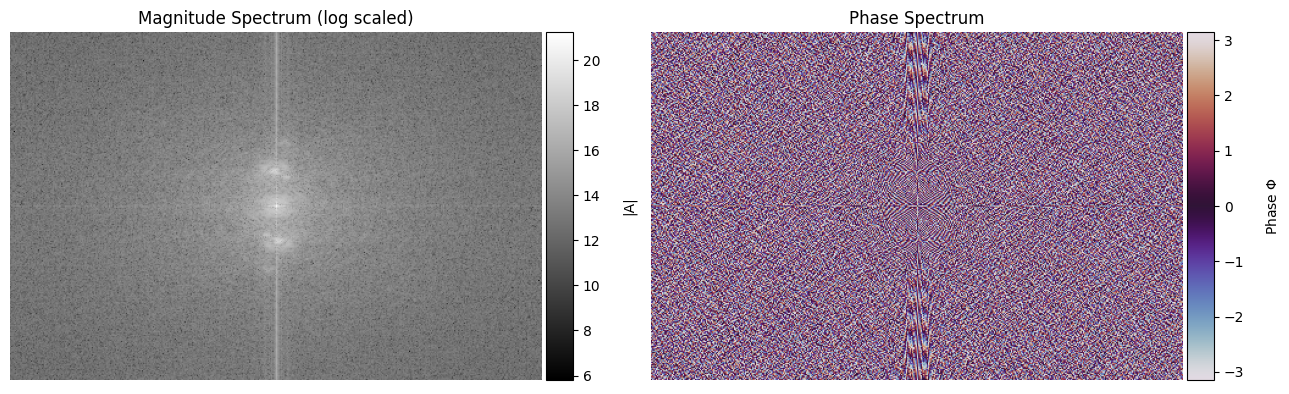

In [6]:
utils.plot_fft_spectra(padded_img, cmap_mag = 'gray')
# utils.plot_fft_spectra(padded_ref)

# Fourier transform - automatic phase extraction pt1
1. Function for FFT
2. Function to find diffraction peaks
3. Function for elliptical mask
4. Extract phase

{'center': (142, 218), 'plus1': (np.int64(113), np.int64(216)), 'minus1': (np.int64(171), np.int64(220))}
28


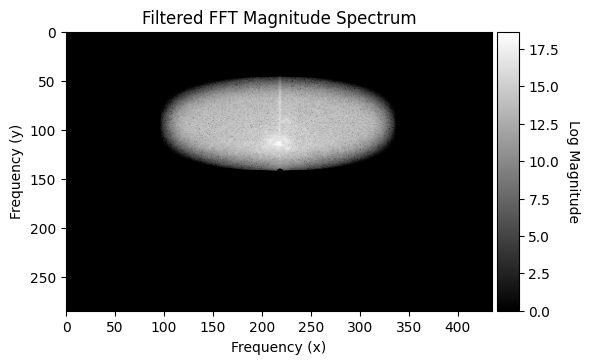

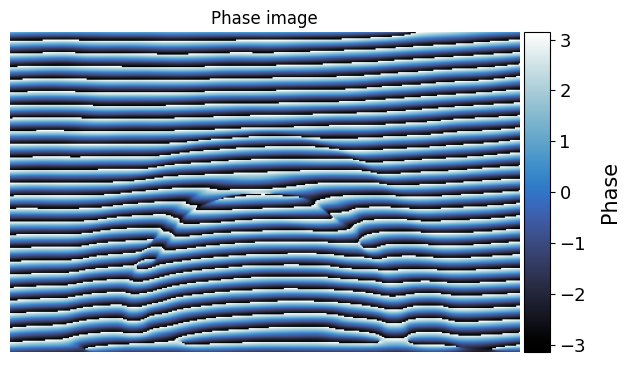

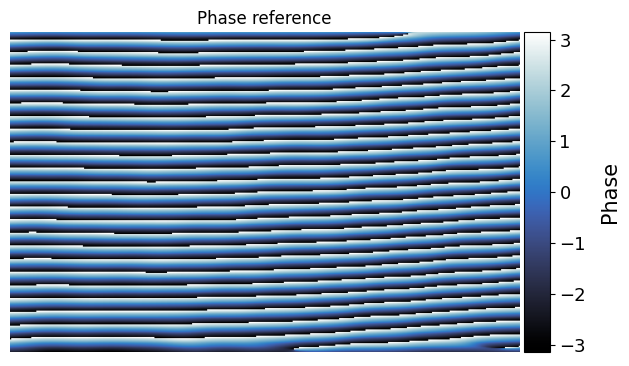

In [7]:
# isolate the -1st-order peak and get its phase map
exclude_radius_peaks = 8
smooth_spectra_sigma = 2
spectr_peaks = functions_phase_shift.find_fourier_peaks(padded_img,exclude_radius = exclude_radius_peaks,smooth_sigma=smooth_spectra_sigma)
print(spectr_peaks)
# extract the first coordinate of ‘center’ and ‘plus1’
peak_name = 'plus1'  # or 'plus1' -> above center, or 'minus1' -> below center
if peak_name == 'plus1':
    y_peak = int(spectr_peaks['plus1'][0])
    x_peak = int(spectr_peaks['plus1'][1])
elif peak_name == 'minus1':
    y_peak = int(spectr_peaks['minus1'][0])
    x_peak = int(spectr_peaks['minus1'][1])
else:
    raise ValueError(f"Unknown peak_name: {peak_name!r}")
y_peak_c = int(spectr_peaks['center'][0])
x_peak_c = int(spectr_peaks['center'][1])

### ------ Collective parameters ------
spectr_peak_distance = abs(y_peak_c - y_peak) - 1  # distance from center = b value of the mask
print(spectr_peak_distance)

y_peak_shift = True # 1064 nm = True
shift_val = 20
if y_peak_shift:
    if peak_name == 'plus1':
        shift_val = -20 # shift mask up (-)#num
    elif peak_name == 'minus1':
        shift_val = 20 # down (+)#num
    y_peak = y_peak + shift_val  

rows, cols = padded_img.shape
a = 100 # x-axis mask
b = spectr_peak_distance # y-axis mask
inner_radius_mask = 3 # mask out middle
mask_sigma = 5 # smooth out filtration mask
####
maskino_spectrino = functions_phase_shift.create_ellipse_mask(
        shape=(rows, cols),
        x_center=x_peak,
        y_center=y_peak,
        a= a,
        b= b,
        sigma=mask_sigma
    )
maskino_spectrino_center = functions_phase_shift.circular_exclusion_mask(
    shape=(rows, cols),
    center=(y_peak_c,x_peak_c),
    radius=3
)

# inferno_cmap = plt.get_cmap('gray')  # this is the Colormap instance
# global_functions_im.plot_image(maskino_spectrino_center, cmap=cmr.cosmic)
fig = utils.plot_filtered_fft_spectrum(img_padded=padded_img, mask=maskino_spectrino, extra_mask=maskino_spectrino_center)
# -----
phase_map_im = functions_phase_shift.compute_phase_from_padded(
    img_padded=padded_img,
    order=peak_name,
    exclude_radius=exclude_radius_peaks, # to find peaks outside
    smooth_sigma=smooth_spectra_sigma, # smooth spectrum to find peaks better
    a_div=a,
    b_div=b,
    mask_sigma=mask_sigma, # gauss filter mask
    pad = p # padding crop after computation
)
phase_map_ref = functions_phase_shift.compute_phase_from_padded(
    img_padded=padded_ref,
    order=peak_name,
    exclude_radius=exclude_radius_peaks,
    smooth_sigma=smooth_spectra_sigma,
    a_div=a,
    b_div=b,
    mask_sigma=mask_sigma,
    pad = p
)
# Colormap('cmap:red')
fig = global_functions_im.plot_image(phase_map_im, title='Phase image', cmap=cmr.arctic, colorbar_label='Phase') # arctic
fig = global_functions_im.plot_image(phase_map_ref, title='Phase reference', cmap=cmr.arctic, colorbar_label='Phase') # arctic
# global_utils.save_plot_as_png(r'C:\Users\User\z\Desktop\WUT\Diplomka\ZPRACOVÁNÍ\Data testing\processing_project\Abel-inversion\output\phase_a100_b30_sgm_1(2).png', fig)

# Fourier transform - automatic phase extraction pt2
(4) Extract phase
- Phase shift + modulo

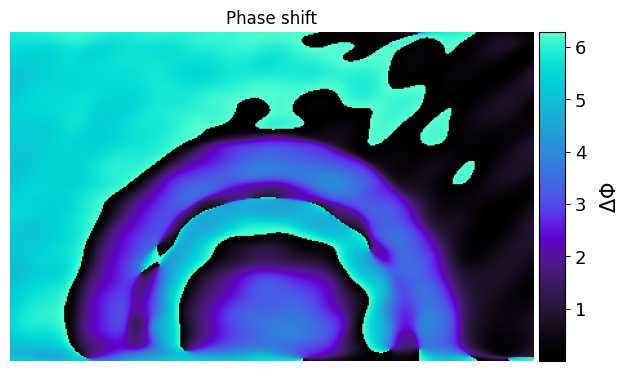

In [8]:
phase_shift = phase_map_ref - phase_map_im
phase_shift = np.mod(phase_shift, 2 * np.pi) # modulo 2pi

fig = global_functions_im.plot_image(phase_shift, title='Phase shift', cmap=cmr.cosmic,colorbar_label='$\Delta\Phi$') # arctic
# global_utils.save_plot_as_png(r'C:\Users\User\z\Desktop\WUT\Diplomka\ZPRACOVÁNÍ\Data testing\processing_project\Abel-inversion\output\phaseshift_a100_b15_sgm_1.png', fig)

# Abel inversion - prep 1
1. Crop base - important for better results
2. Phase unwrap 
3. Mask the phase unwrapped image

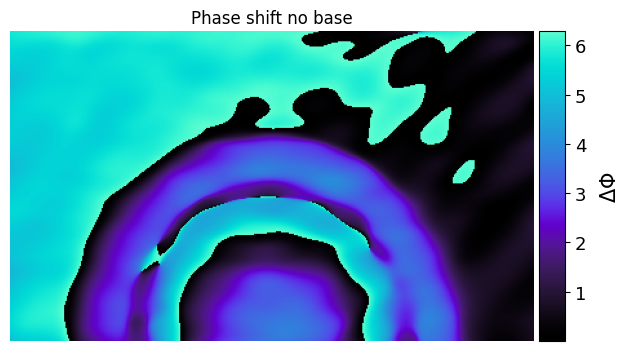

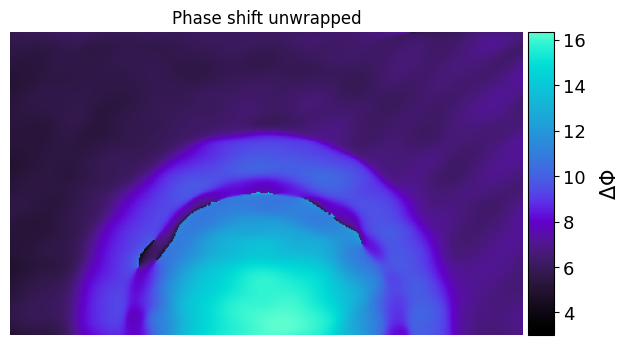

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x291c2e1d550>)

In [9]:
## --- CROP base ---
base_crop = 15
phase_shift_crop = functions_phase_shift.crop_img_base(phase_shift, base_crop)
fig = global_functions_im.plot_image(phase_shift_crop, title='Phase shift no base', cmap=cmr.cosmic,colorbar_label='$\Delta\Phi$') # arctic

## --- Phase UNWRAP with step function algorithms ---
image_unwrapped = functions_phase_shift.unwrap_phase_image(phase_shift_crop)
global_functions_im.plot_image(image_unwrapped, title='Phase shift unwrapped', cmap=cmr.cosmic,colorbar_label='$\Delta\Phi$') 
# prinsenvlag, iceburn, redshift
# global_functions_im.save_tiff(image_unwrapped, r"C:\Users\User\z\Desktop\WUT\Diplomka\ZPRACOVÁNÍ\Data testing\processing_project\Abel-inversion\output\random_test.jpg")
#plot_image(image_unwrapped, title='Phase shift', cmap=cmr.redshift) # prinsenvlag, iceburn, redshift

# Abel inversion - prep 2
Now we select a single row and make an Abel transform. However before that the data needs to get pre-processed. This can go few different ways.
1. Everything where (r > R) = 0 -> masking out the plasma
2. Symmetrize data by:
a) remove linear tilt: subtract a best‐fit straight line from that 1D signal to correct any sloping background.
b) Average Left and Right: enforce perfect symmetry about the chosen centre by replacing each pair of equidistant points with their average.
-- OR --
a) Use 1D fourier transform: you can enforce even symmetry by projecting out the odd component in the transform domain. For any 1D real signal h(x), its Fourier transform H(k)=F{h}(k) can be split into H(k)=H(k)_even + iH(k)_odd where H(k)_even =ℜ{H(k)}. The inverse transform of just the real part gives you the even (symmetric) component.

240 406
203


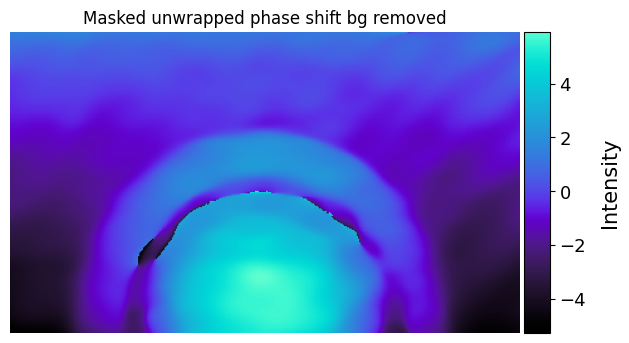

vmin=-5.285272236388885, vmax=5.9337101379644634
bg shape: (240, 406) min/max: -3.540194937375479 4.528225659020533
coeffs: -1.4097933564166385 -0.005260250817182323 0.024845267847017453


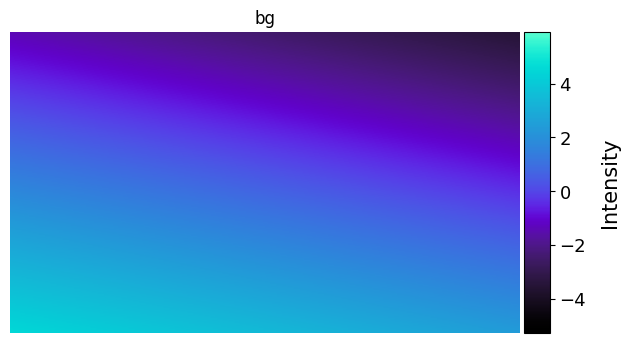

<class 'numpy.ndarray'>


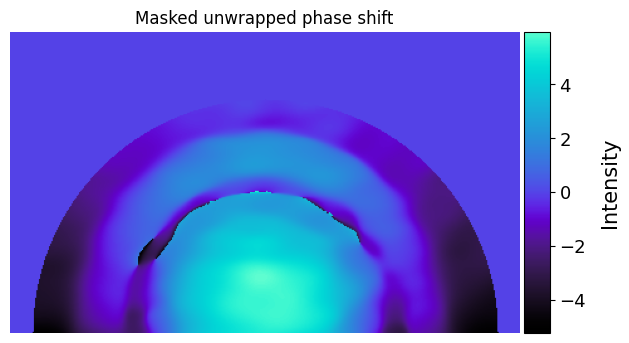

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x291c48c90d0>)

In [20]:
## --- 1. Mask plasma ---
rows, cols = image_unwrapped.shape
mask_radius = 185
# y0 at the last row (base of the image), x0 at the horizontal midpoint
y0 = rows - 1  # bottom row of an image
x0 = cols // 2  # middle column of an image
print(rows, cols)
print(x0)
semicircle_mask = functions_abel.make_semicircle_mask((rows, cols),
                         center = (y0, x0),
                         radius =  mask_radius,
                         smooth_sigma = None)

# fit polynomial - remove background:
bool_tilt_masked = False
if bool_tilt_masked:
    mask_flipped = 1 - semicircle_mask.astype(bool) # I need the outside
    bg, coeffs = functions_phase_shift.fit_plane_background(image_unwrapped, mask=mask_flipped)
else:
    bg, coeffs = functions_phase_shift.fit_plane_background(image_unwrapped)

image_unwrapped = image_unwrapped - bg # remove background

bool_normalise_phase = True
if bool_normalise_phase: # normalise to 0
    image_unwrapped = functions_abel.normalize_image(image_unwrapped, force_zero=True) # normalise
    
fig, axes_im = global_functions_im.plot_image(image_unwrapped, title='Masked unwrapped phase shift bg removed', cmap=cmr.cosmic)
vmin, vmax = axes_im.get_clim()
print(f"vmin={vmin}, vmax={vmax}")
print("bg shape:", bg.shape,
      "min/max:", bg.min(), bg.max())
c0, c_x, c_y = coeffs
print("coeffs:", c0, c_x, c_y)

global_functions_im.plot_image(bg,
                      title="bg",
                      match_scale=(vmin, vmax),
                      cmap=cmr.cosmic)
# global_functions_im.plot_image(bg, title='bg', match_scale = axes_im, cmap=cmr.cosmic)
print(type(bg))

masked_plasma = image_unwrapped * semicircle_mask
global_functions_im.plot_image(masked_plasma, title='Masked unwrapped phase shift', cmap=cmr.cosmic)

# Abel transform 1D
methods in PyAbel package

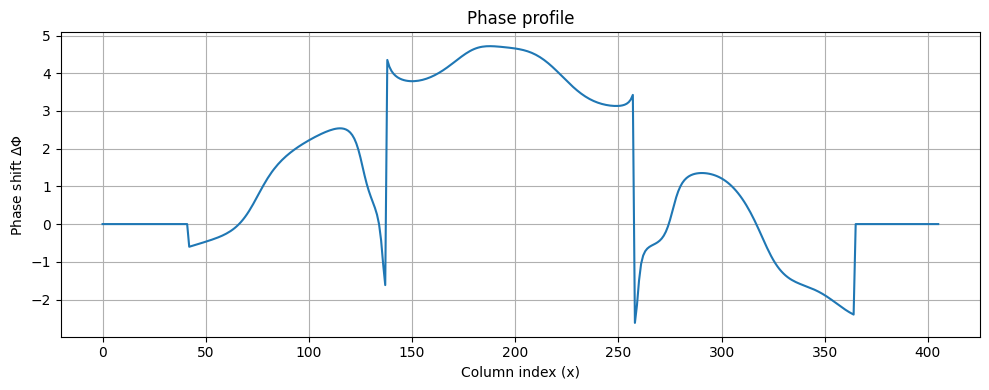

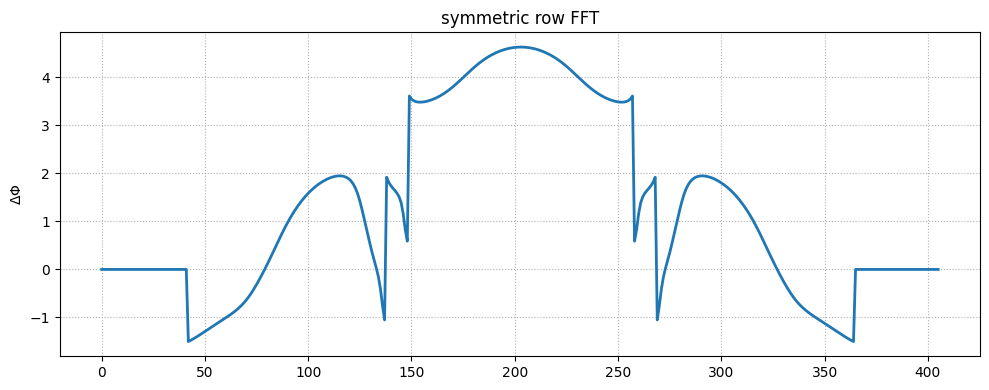

406
203
203
Loading basis sets...
(cropped from basex_basis_341_2.0.npy)
Updating regularization...
Calculating correction...


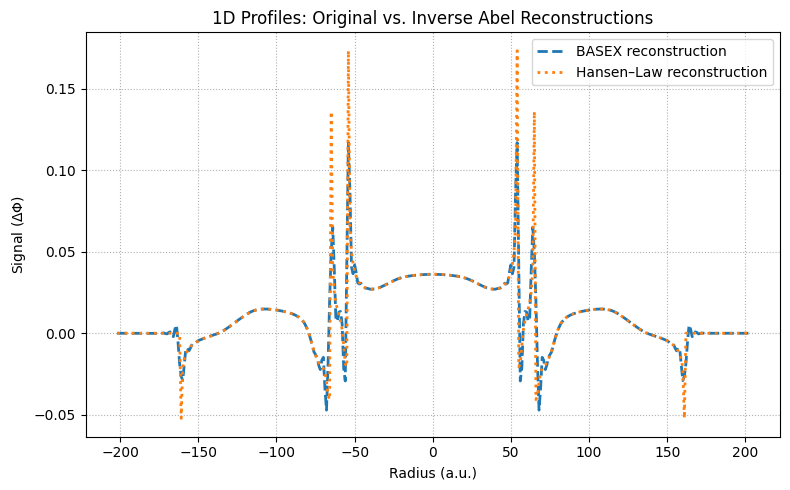

In [11]:
## --- 2. Symmetrization ---
row = y0 - 90
utils.plot_image_row(masked_plasma, row= row, title="Phase profile")

## --- (A) 1D fourier transform ---
symmetric_row_FFT = functions_abel.symmetrize_via_fft(masked_plasma[row, :])
utils.plot_1d_profile(symmetric_row_FFT,title='symmetric row FFT',xlabel='',ylabel='$\Delta\Phi$')

## --- (B) Remove linear tilt, average left and right  ---
# remove_tilt = functions_abel.remove_linear_tilt(masked_plasma[row, :])
# utils.plot_intensity(remove_tilt) 
# symmetric_row = functions_abel.symmetrize_profile(
#        remove_tilt,
#        side = "both"
# )
# utils.plot_intensity(symmetric_row) 

# --- crop data in the axis of symmetry ---
# (or, if your axis isn’t exactly the midpoint, find it by some feature:)
c1 = symmetric_row_FFT.argmax()
c2 = symmetric_row_FFT.size // 2
print(symmetric_row_FFT.size) # 232 x 682
print(c1)
print(c2) # integer‐division midpoint as symmetry column

# 1D data:
half_profile = symmetric_row_FFT[c1:]

# Now run the inverse‐Abel on that half-profile:
dr = 1
inv_basex = functions_abel.inverse_abel(half_profile, method = 'basex', reg = 10, dr = dr)
inv_hansenlaw = functions_abel.inverse_abel(half_profile, method = 'hansenlaw', dr = dr)

# 1) build the half-axis
r_half = np.arange(half_profile.size) * dr # produces the array [0, 1, 2, …, N-1] where N is the length of your half-profile.
# 2) mirror them
r_full_both       = functions_abel.mirror_array(r_half,flip_sign=True)   # same for both methods
f_full_basex      = functions_abel.mirror_array(inv_basex,flip_sign=False)
f_full_hansenlaw  = functions_abel.mirror_array(inv_hansenlaw,flip_sign=False)
# 3) Data adjustment
# f_full_basex = np.maximum(f_full_basex, 0) # make all negative values = 0

# 6) Plot all three
plt.figure(figsize=(8,5))
plt.plot(r_full_both, f_full_basex,     label='BASEX reconstruction',      lw=2, ls='--')
plt.plot(r_full_both, f_full_hansenlaw, label='Hansen–Law reconstruction', lw=2, ls=':')
plt.xlabel('Radius (a.u.)')
plt.ylabel('Signal ($\Delta\Phi$)')
plt.title('1D Profiles: Original vs. Inverse Abel Reconstructions')
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

# Abel transform 2D
Full image profile reconstruction
a) symmetrize plasma image + smooth the profile if needed
b) slice the image in the axis of symmetry
c) Abel transform whole (half) image
d) Mirror the Abel data to form the whole image again

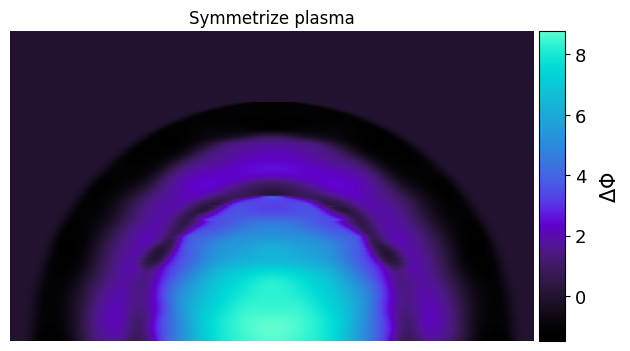

240
406


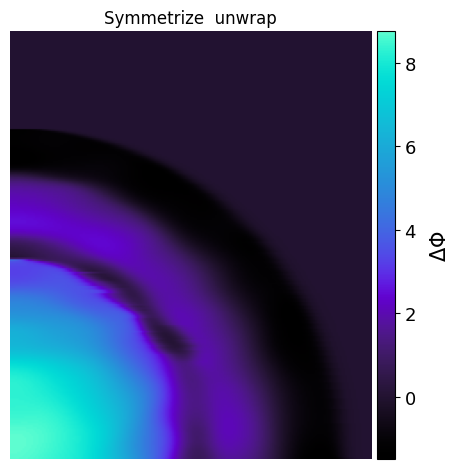

Loading basis sets...
(cropped from basex_basis_341_3.0.npy)
Updating regularization...
Calculating correction...


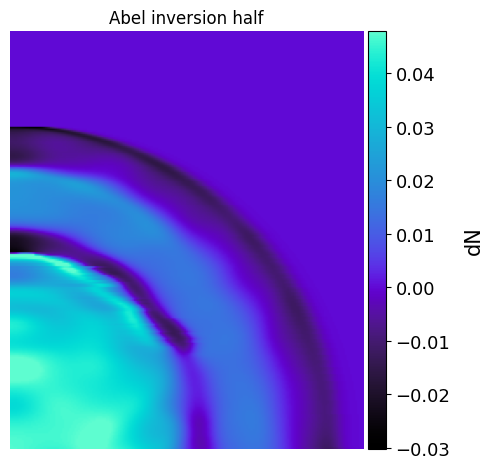

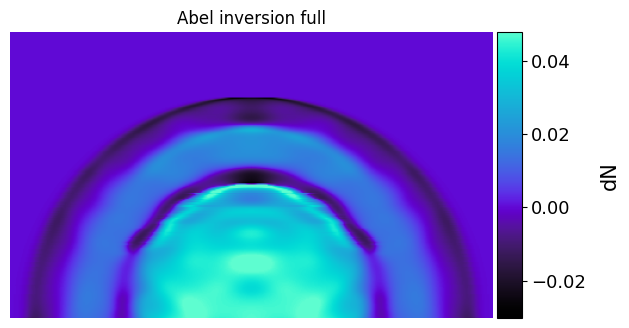

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x291c3f9de90>)

In [12]:
symmetrize_plasma = functions_abel.symmetrize_plasma_img(masked_plasma, n_rows = mask_radius, gaussian_sigma = 5,
    smooth_per_row = True)
global_functions_im.plot_image(symmetrize_plasma, title='Symmetrize plasma', colorbar_label='$\Delta\Phi$', cmap=cmr.cosmic)
print(symmetrize_plasma.shape[0])
print(symmetrize_plasma.shape[1])

# Half of the image:
# a 2D m×n array: a half‐image where [:,0] is the symmetry axis
row_center = symmetrize_plasma.shape[1] // 2
# right side so that half[:,0] is on the axis, row_center = index column of symmetry
# ---- ZDE MOHU VYČÍSLIT SYMETRIČNOST! -> masked_plasma[:, row_center:]; masked_plasma[:, :row_center] ---- 
half_img = symmetrize_plasma[:, row_center:] 
global_functions_im.plot_image(half_img, title='Symmetrize  unwrap', colorbar_label='$\Delta\Phi$', cmap=cmr.cosmic)
# full_profile  = image_unwrapped[row_center, :].astype(float)

# Now run the inverse‐Abel on that half-profile:
dr = 1
inv_basex = functions_abel.inverse_abel(half_img, method = 'basex', sigma = 3,
    reg = 10, dr = dr)
global_functions_im.plot_image(inv_basex, title='Abel inversion half', colorbar_label='dN', ignore_top_percent = 1, cmap=cmr.cosmic)

# Mirror data to get full 2D profile:
inv_basex_full = functions_abel.mirror_image(inv_basex)
global_functions_im.plot_image(inv_basex_full, title='Abel inversion full', colorbar_label='dN', ignore_top_percent = 1, cmap=cmr.cosmic)

# Output electron dentsity + tighter crop

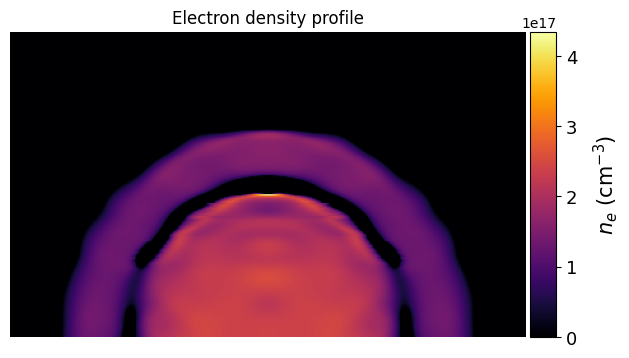

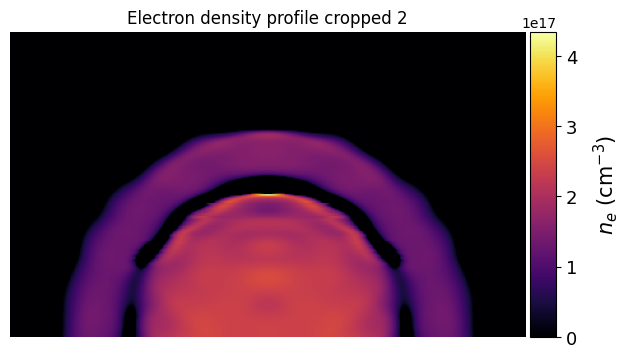

1.2844418617358114e+17


In [13]:
electron_density = functions_abel.compute_electron_density(inv_basex_full)
global_functions_im.plot_image(electron_density, title='Electron density profile', colorbar_label=r'$n_e\ \mathrm{(cm^{-3})}$', cmap='inferno')


rows, cols = inv_basex_full.shape
# y0 at the last row (base of the image), x0 at the horizontal midpoint
y0 = rows - 1
x0 = cols // 2 # middle of an image
"""
mask_plasma = 62
semicircle_mask_2 = functions_abel.make_semicircle_mask((rows, cols),
                         center = (y0, x0),
                         radius =  mask_plasma,
                         smooth_sigma = None)

electron_density_cropped = electron_density * semicircle_mask_2
global_functions_im.plot_image(electron_density_cropped, title='Electron density profile cropped', colorbar_label=r'$n_e\ \mathrm{(cm^{-3})}$', cmap='inferno')
"""

# mask 2
r2 = mask_radius - 10
semicircle_mask_3 = functions_abel.make_semicircle_mask((rows, cols),
                         center = (y0, x0),
                         radius =  r2,
                         smooth_sigma = None)
electron_density_cropped_2 = electron_density * semicircle_mask_3
global_functions_im.plot_image(electron_density_cropped_2, title='Electron density profile cropped 2', colorbar_label=r'$n_e\ \mathrm{(cm^{-3})}$', cmap='inferno')

# calculate average electron density
integrated_ne = functions_electron_density_analysis.masked_average(electron_density_cropped_2, semicircle_mask_3)
print(integrated_ne)

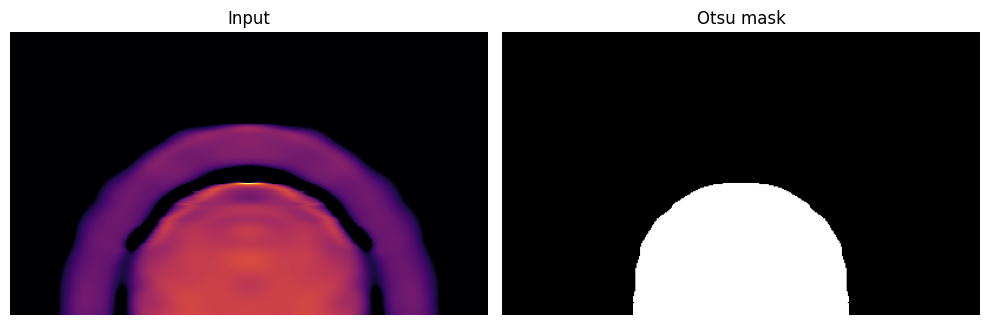

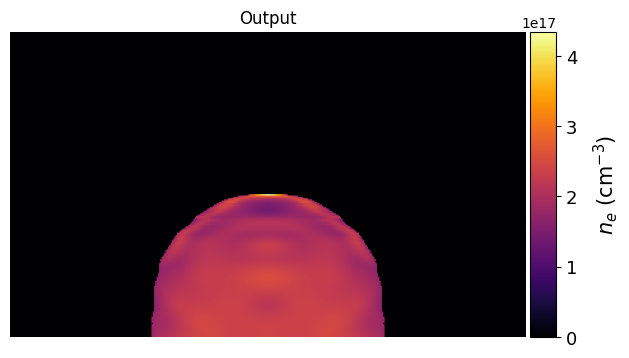

2.1608207171083293e+17
(240, 371)


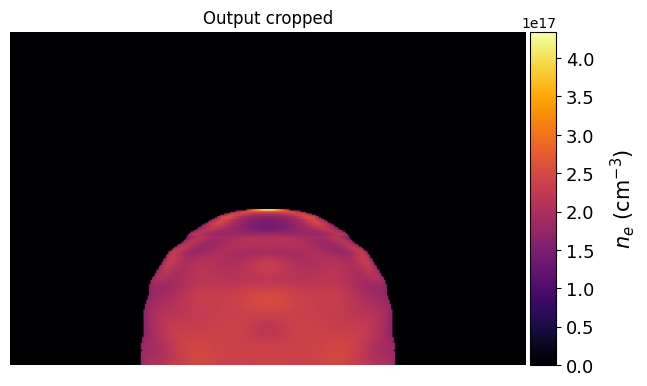

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x291c48a3490>)

In [21]:
#baseline = np.median(electron_density_cropped_2)
#dev = electron_density_cropped_2 - baseline
# a = np.abs(dev)

#mask, thr = functions_electron_density_analysis.otsu_binary_mask(electron_density_cropped_2, min_hole_size=1, keep_largest = False)# 
# print("Otsu threshold:", thr)
from scipy.ndimage import binary_closing
# structure = np.ones((10,10), dtype=bool)
# mask = binary_closing(mask, structure=structure)

mask, threshold = functions_electron_density_analysis.otsu_binary_mask(
    electron_density_cropped_2,
    method='multiotsu',
    n_classes=3,
    remove_small=5,
    close_size=20,       # use a 10×10 closing structuring element
    gaussian_sigma = 3,
    keep_largest=True
)
mask = functions_electron_density_analysis.fill_bottom_rectangle(mask)

global_functions_im.plot_two_images(electron_density_cropped_2, mask, title1='Input',title2='Otsu mask', cmap1='inferno', cmap2='gray')

plasma_shape_mask = electron_density_cropped_2 * mask
global_functions_im.plot_image(plasma_shape_mask, title='Output', colorbar_label=r'$n_e\ \mathrm{(cm^{-3})}$', cmap='inferno') # cmap=cmr.cosmic) # prinsenvlag, iceburn, redshift

# calculate average electron density
integrated_ne = functions_electron_density_analysis.masked_average(electron_density_cropped_2,mask)
print(integrated_ne)

plasma_shape_mask_cropped = utils.crop_three_sides(plasma_shape_mask,r=mask_radius)
print(plasma_shape_mask_cropped.shape)
global_functions_im.plot_image(plasma_shape_mask_cropped , title='Output cropped', colorbar_label=r'$n_e\ \mathrm{(cm^{-3})}$', cmap='inferno') # cmap=cmr.cosmic) # prinsenvlag, iceburn, redshift

# 2D slice of a single row

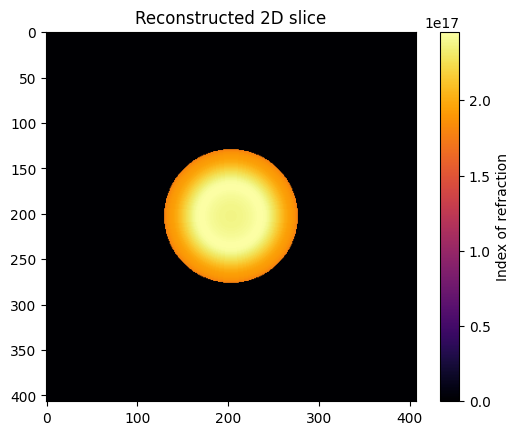

In [15]:
img = functions_abel.revolve_profile_to_image(plasma_shape_mask_cropped[-10,:], center_idx=row_center, interp=False)

plt.imshow(img, cmap='inferno')
plt.colorbar(label='Index of refraction')
plt.title('Reconstructed 2D slice')
plt.show()